In [105]:
import os

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint

In [106]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Experiment results saving directory
results_dir = os.path.join("experiment_results")


In [107]:
# ==========================================
# 1. Exact Solution (Ground Truth)
# ==========================================
def burguers_numerical_solution(n_x=200, n_t=200, L=1.0, T=1.0):
    """
    Computes the exact solution for Burgers' equation using
    Method of Lines (high-resolution finite difference)
    to serve as Ground Truth.
    """
    nu = 0.01 / np.pi
    x = np.linspace(0, L, n_x)
    t = np.linspace(0, T, n_t)
    dx = x[1] - x[0]

    # Initial Condition: -sin(pi * x)
    u0 = np.sin(2 * np.pi * x / L)

    # Discretized PDE function for odeint
    def burgers_rhs(u, t, nu, dx):
        # u_xx (Central difference)
        u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
        # u_x (Central difference)
        u_x = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

        # Dirichlet BCs (u=0 at boundaries) -> Enforce 0 derivative updates at ends
        dudt = -u * u_x + nu * u_xx
        dudt[0] = 0
        dudt[-1] = 0
        return dudt

    # Integrate in time
    u_exact = odeint(burgers_rhs, u0, t, args=(nu, dx))

    # Meshgrid for plotting
    t_grid, x_grid = np.meshgrid(t, x)
    return x_grid, t_grid, u_exact.T  # Transpose to match (x, t)


In [108]:
# ==========================================
# 2. Data Generation (PINN)
# ==========================================
def generate_burgers_data(n_boundary, n_domain, L=1.0, T=1.0):
    """Generates collocation points for training."""

    # --- Boundary Conditions (BC) ---
    # x=0, x=1, t=0
    n_each = n_boundary // 3

    # --- BC: x = 0 ---
    x_bc1 = np.zeros((n_each, 1))
    t_bc1 = np.random.uniform(0, T, (n_each, 1))
    u_bc1 = np.zeros((n_each, 1))

    # --- BC: x = L ---
    x_bc2 = L * np.ones((n_each, 1))
    t_bc2 = np.random.uniform(0, T, (n_each, 1))
    u_bc2 = np.zeros((n_each, 1))

    # --- IC: t = 0 ---
    x_ic = np.random.uniform(0, L, (n_each, 1))
    t_ic = np.zeros((n_each, 1))
    u_ic = np.sin(2 * np.pi * x_ic / L)

    Xb = np.vstack([x_bc1, x_bc2, x_ic])
    Tb = np.vstack([t_bc1, t_bc2, t_ic])
    Ub = np.vstack([u_bc1, u_bc2, u_ic])

    # --- Domain Points ---
    x_dom = np.random.uniform(0, L, (n_domain, 1))
    t_dom = np.random.uniform(0, T, (n_domain, 1))
    Xd = np.hstack([x_dom, t_dom])

    # converter para tensor
    inputs_bc = torch.tensor(np.hstack([Xb, Tb]), dtype=torch.float32)
    targets_bc = torch.tensor(Ub, dtype=torch.float32)

    inputs_pde = torch.tensor(Xd, dtype=torch.float32, requires_grad=True)

    return inputs_bc, targets_bc, inputs_pde

In [109]:
# ==========================================
# 3. Model & Physics
# ==========================================
class BurgersPINN(nn.Module):
    def __init__(self, layers=[2, 20, 20, 20, 20, 1]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        return self.net(x)


def calculate_physics_residual(model, inputs_pde):
    """Calculates f = u_t + u*u_x - nu*u_xx"""
    u = model(inputs_pde)

    grads = torch.autograd.grad(
        u, inputs_pde, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]
    u_xx = torch.autograd.grad(
        u_x, inputs_pde, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1]

    nu = 0.01 / np.pi
    return u_t + (u * u_x) - (nu * u_xx)


In [110]:
# ==========================================
# 4. Training Functions
# ==========================================
def train_standard(model, inputs_bc, targets_bc, inputs_pde, alpha, epochs=3000):
    print("\n--- Standard Training ---")
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    # Modification: history is now a dictionary to store all loss components
    history = {"loss": [], "loss_bc": [], "loss_pde": []}

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        # 1. Boundary Condition Loss (Data-driven loss)
        loss_bc = loss_fn(model(inputs_bc), targets_bc)
        # 2. PDE Residual Loss (Physics-driven loss)
        loss_pde = torch.mean(calculate_physics_residual(model, inputs_pde) ** 2)

        # Weighted Total Loss (Fixed weights: 1-alpha and alpha)
        loss = (1 - alpha) * loss_bc + alpha * loss_pde

        loss.backward()
        optimizer.step()

        # Record losses
        history["loss"].append(loss.item())
        history["loss_bc"].append(loss_bc.item())
        history["loss_pde"].append(loss_pde.item())

        if epoch % 1000 == 0:
            print(
                f"Epoch {epoch}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f}, PDE: {loss_pde.item():.5f})"
            )
    return history


def train_adaptive(model, inputs_bc, targets_bc, inputs_pde, epochs=3000):
    print("\n--- Adaptive Training (Uncertainty Weighting) ---")
    device = inputs_bc.device
    model.to(device)
    model.train()

    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)
    # s_bc and s_pde are trainable log-variance parameters
    s_bc = torch.tensor(2.0, requires_grad=True, device=device)
    s_pde = torch.tensor(1.0, requires_grad=True, device=device)
    optimizer_w = optim.Adam([s_bc, s_pde], lr=1e-3)  # Optimizer for the log-variances
    loss_fn = nn.MSELoss()
    # Modification: history includes individual losses and adaptive weights
    history = {"loss": [], "loss_bc": [], "loss_pde": [], "w_bc": [], "w_pde": []}

    for epoch in range(epochs):
        optimizer_model.zero_grad()
        optimizer_w.zero_grad()

        loss_bc = loss_fn(model(inputs_bc), targets_bc)
        loss_pde = torch.mean(calculate_physics_residual(model, inputs_pde) ** 2)

        # Adaptive Loss formulation (Equation 11 from the PINN paper by Z. Xiang et al., 2022)
        # L_total = exp(-s_bc) * L_bc + exp(-s_pde) * L_pde + s_bc + s_pde
        loss = (
            1 / 2 * torch.exp(-s_bc) * loss_bc
            + 1 / 2 * torch.exp(-s_pde) * loss_pde
            + s_bc
            + s_pde
        )

        loss.backward()
        optimizer_model.step()
        optimizer_w.step()

        # Record losses and calculated weights (w = exp(-s))
        w_bc_val = torch.exp(-s_bc).item()
        w_pde_val = torch.exp(-s_pde).item()

        history["loss"].append(loss.item())
        history["loss_bc"].append(loss_bc.item())
        history["loss_pde"].append(loss_pde.item())
        history["w_bc"].append(w_bc_val)
        history["w_pde"].append(w_pde_val)

        if epoch % 1000 == 0:
            print(
                f"Epoch {epoch}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f}, PDE: {loss_pde.item():.5f}, w_bc: {w_bc_val:.2f}, w_pde: {w_pde_val:.2f})"
            )
    return history

In [111]:
# ==========================================
# 5. Execution
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Generate Data
inputs_bc, targets_bc, inputs_pde = generate_burgers_data(600, 1000)
inputs_bc, targets_bc, inputs_pde = (
    inputs_bc.to(device),
    targets_bc.to(device),
    inputs_pde.to(device),
)

# Convert Tensors to Numpy for Plotly (must be on CPU)
X_bc_np = inputs_bc.cpu().detach().numpy()  # Boundary Points
X_pde_np = inputs_pde.cpu().detach().numpy()  # Domain/Equation Points

print(
    f"Plotting {len(X_bc_np)} boundary points and {len(X_pde_np)} collocation points..."
)

# Create Scatter for Boundary Points (Blue by default)
# Column 0 is x, Column 1 is t
scatter_bc = px.scatter(
    x=X_bc_np[:, 0],
    y=X_bc_np[:, 1],
    labels={"x": "x", "y": "t"},
    title="Boundary Points",
)
# Rename trace for legend
scatter_bc.data[0].name = "Boundary (BC/IC)"
scatter_bc.data[0].showlegend = True

# Create Scatter for PDE/Equation Points (Red)
scatter_pde = px.scatter(
    x=X_pde_np[:, 0], y=X_pde_np[:, 1], color_discrete_sequence=["red"]
)
# Rename trace for legend
scatter_pde.data[0].name = "Collocation Points (PDE)"
scatter_pde.data[0].showlegend = True
# Make points smaller and slightly transparent
scatter_pde.update_traces(marker=dict(size=4, opacity=0.5))

# Combine Plots
fig = go.Figure(data=scatter_bc.data + scatter_pde.data)

# Layout adjustments
fig.update_layout(
    title="Distribution of Training Points (x vs t)",
    xaxis_title="Space (x)",
    yaxis_title="Time (t)",
    legend_title="Point Type",
    width=800,
    height=600,
)

fig.show()


Using device: cuda
Plotting 600 boundary points and 1000 collocation points...


In [112]:
# --- Visualization of Boundary Conditions in 3D (x, t, u) ---

# Data for 3D plot: x (space), t (time), u (target value)
# Note: The 'u' values (targets_bc_np) are required for the z-axis.
targets_bc_np = targets_bc.cpu().detach().numpy()

scatter_3d = px.scatter_3d(
    x=X_bc_np[:, 0].flatten(),
    y=X_bc_np[:, 1].flatten(),
    z=targets_bc_np.flatten(),
    color=targets_bc_np.flatten(),  # Color by u value
    labels={"x": "Space (x)", "y": "Time (t)", "z": "Value (u)"},
    title="Initial and Boundary Conditions in (x, t, u) Space",
)

fig_3d = go.Figure(scatter_3d)
fig_3d.update_layout(
    scene=dict(
        xaxis_title="Space (x)",
        yaxis_title="Time (t)",
        zaxis_title="Value (u)",
        aspectmode="cube",
    ),
    width=800,
    height=600,
    title="Initial and Boundary Conditions in (x, t, u) Space",
)
fig_3d.show()

In [ ]:
# 2. Train Models
pinn_std = BurgersPINN().to(device)
history_std = train_standard(
    pinn_std, inputs_bc, targets_bc, inputs_pde, alpha=0.2, epochs=20000
)

pinn_adapt = BurgersPINN().to(device)
history_adapt = train_adaptive(
    pinn_adapt, inputs_bc, targets_bc, inputs_pde, epochs=20000
)



--- Standard Training ---
Epoch 0: Loss 0.16499 (BC: 0.20615, PDE: 0.00034)


In [ ]:
# ==========================================
# 6. Evaluation & Grid Generation
# ==========================================
# Generate Grid for Visualization
x_grid_np, t_grid_np, u_exact_np = burguers_numerical_solution(200, 200)
X_test = np.hstack((x_grid_np.flatten()[:, None], t_grid_np.flatten()[:, None]))
X_test_tens = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)

# Evaluate Models
pinn_std.eval()
pinn_adapt.eval()

# Predictions
u_pred_std = pinn_std(X_test_tens).detach().cpu().numpy().reshape(x_grid_np.shape)
u_pred_adapt = pinn_adapt(X_test_tens).detach().cpu().numpy().reshape(x_grid_np.shape)


# Residuals (Must compute gradients, so use torch context)
def get_residual_grid(model, X_tensor, shape):
    f = calculate_physics_residual(model, X_tensor)
    return f.detach().cpu().numpy().reshape(shape)


res_std = get_residual_grid(pinn_std, X_test_tens, x_grid_np.shape)
res_adapt = get_residual_grid(pinn_adapt, X_test_tens, x_grid_np.shape)

# Absolute Errors
err_std = np.abs(u_exact_np - u_pred_std)
err_adapt = np.abs(u_exact_np - u_pred_adapt)



--- Plotting Individual Visualization Maps ---


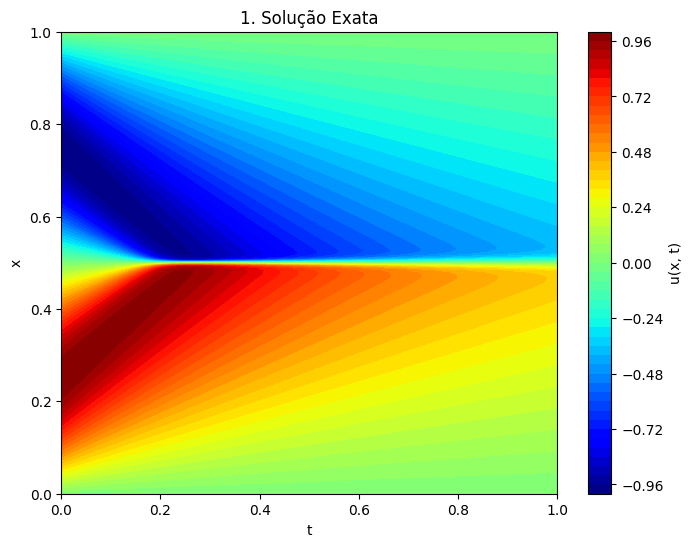

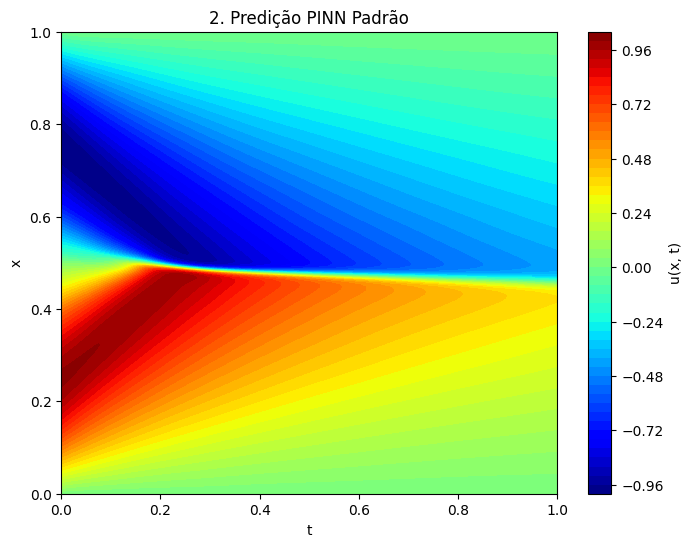

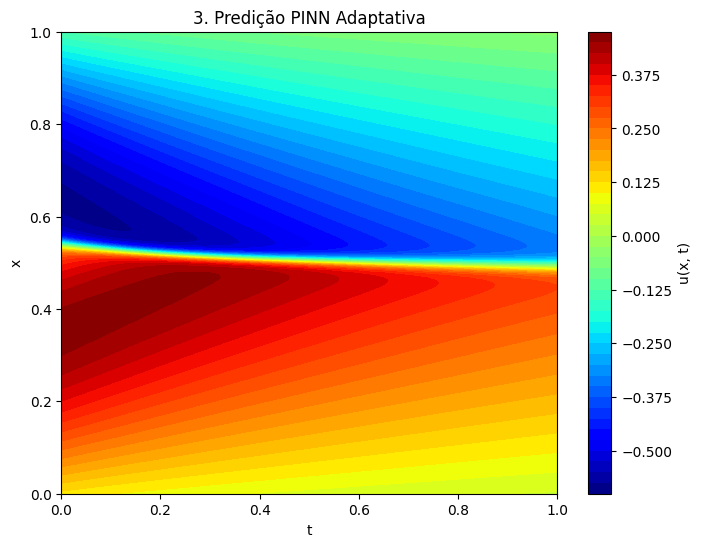

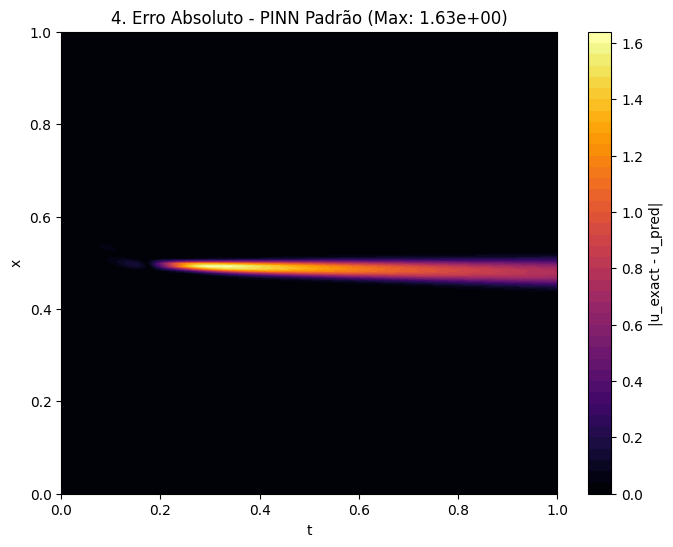

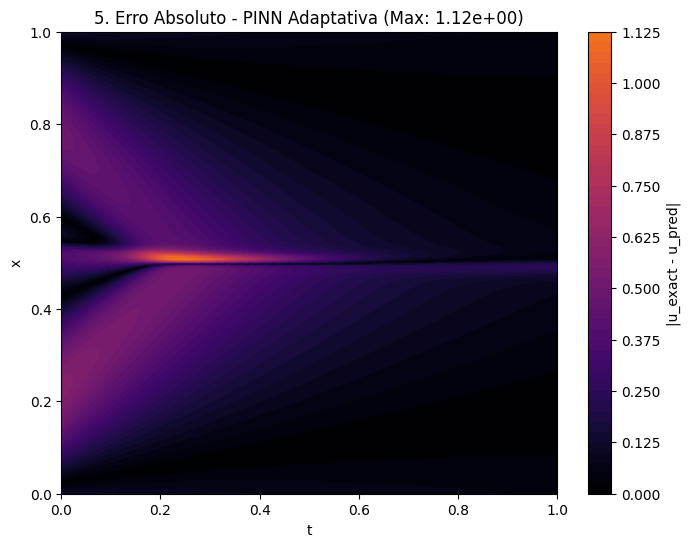

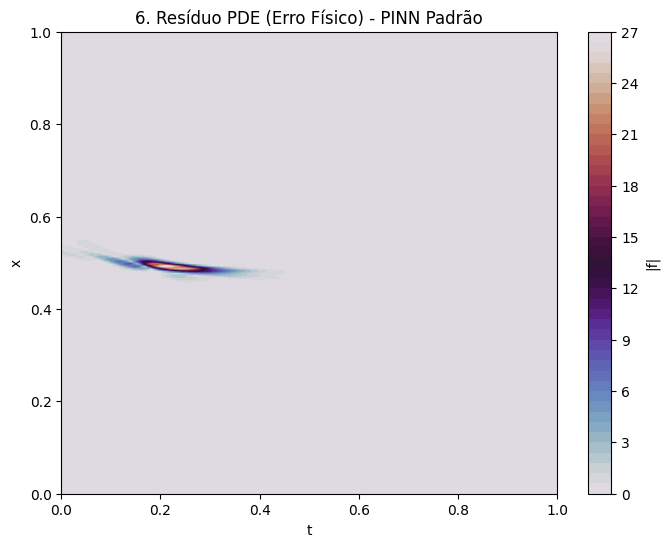

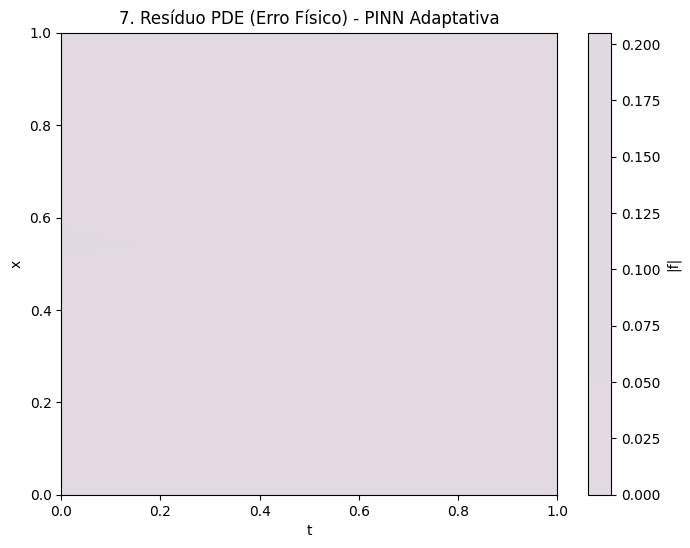


Final MSE Standard: 0.022694
Final MSE Adaptive: 0.043110

--- Plotting Training History ---


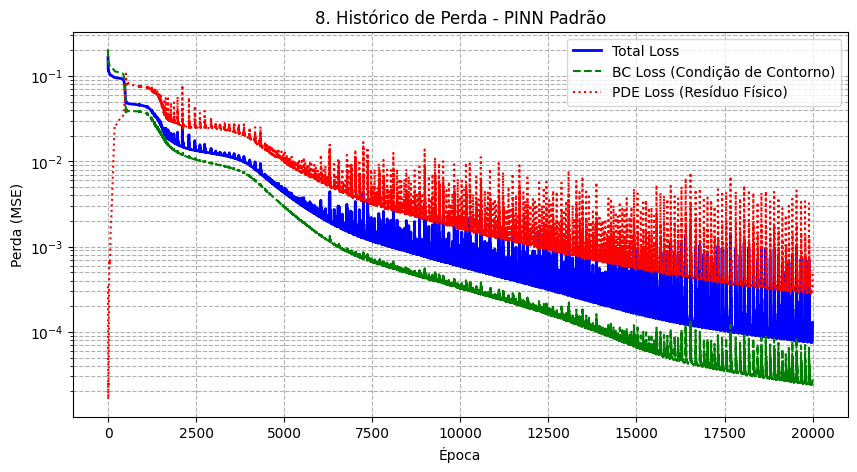

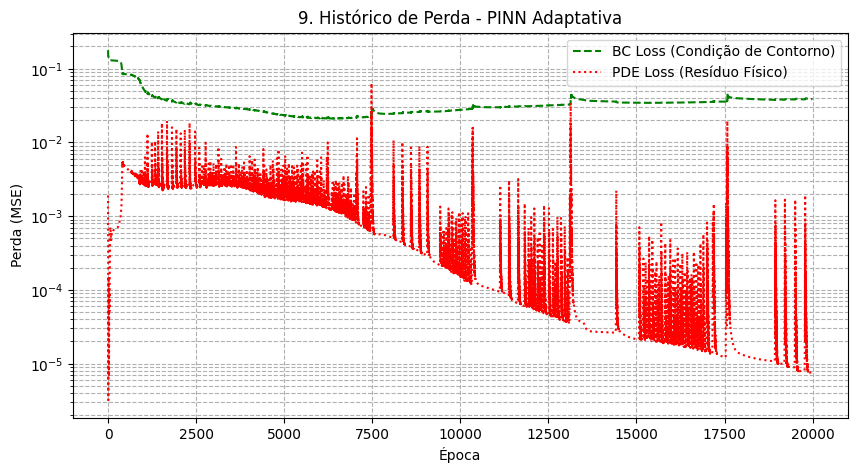

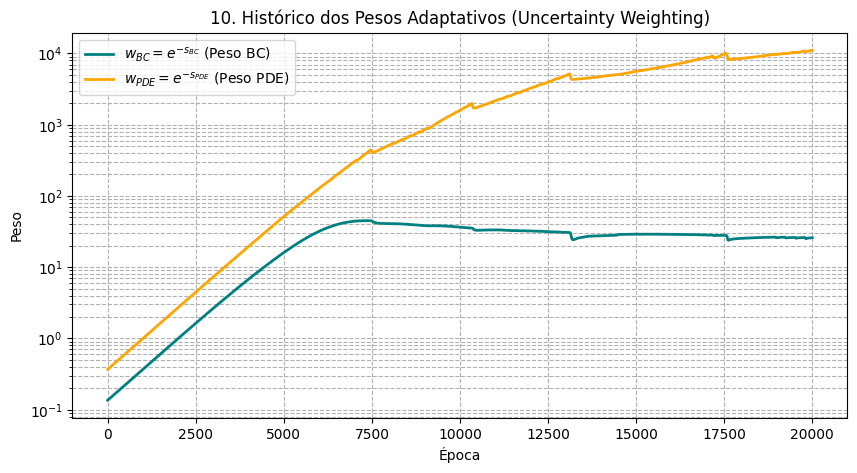

In [ ]:
# ==========================================
# 7. Detailed Visualization
# ==========================================

# Pre-calculate the max error and residual for shared color scales
vmax_err = max(np.max(err_std), np.max(err_adapt))
vmax_res = max(np.max(np.abs(res_std)), np.max(np.abs(res_adapt)))


print("\n--- Plotting Individual Visualization Maps ---")

### 1. Exact Solution
plt.figure(figsize=(8, 6))
c1 = plt.contourf(t_grid_np, x_grid_np, u_exact_np, levels=50, cmap="jet")
plt.title("1. Solução Exata")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c1, label="u(x, t)")
plt.savefig(os.path.join(results_dir, "exact_solution.png"))
plt.show()


### 2. Standard PINN Prediction
plt.figure(figsize=(8, 6))
c2 = plt.contourf(t_grid_np, x_grid_np, u_pred_std, levels=50, cmap="jet")
plt.title("2. Predição PINN Padrão")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c2, label="u(x, t)")
plt.savefig(os.path.join(results_dir, "standard_pinn_prediction.png"))
plt.show()  #


### 3. Adaptive PINN Prediction
plt.figure(figsize=(8, 6))
c3 = plt.contourf(t_grid_np, x_grid_np, u_pred_adapt, levels=50, cmap="jet")
plt.title("3. Predição PINN Adaptativa")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c3, label="u(x, t)")
plt.savefig(os.path.join(results_dir, "adaptive_pinn_prediction.png"))
plt.show()

### 4. Absolute Error - Standard PINN
plt.figure(figsize=(8, 6))
c4 = plt.contourf(
    t_grid_np, x_grid_np, err_std, levels=50, cmap="inferno", vmin=0, vmax=vmax_err
)
plt.title(f"4. Erro Absoluto - PINN Padrão (Max: {np.max(err_std):.2e})")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c4, label="|u_exact - u_pred|")
plt.savefig(os.path.join(results_dir, "absolute_error_standard_pinn.png"))
plt.show()  #


### 5. Absolute Error - Adaptive PINN
plt.figure(figsize=(8, 6))
c5 = plt.contourf(
    t_grid_np, x_grid_np, err_adapt, levels=50, cmap="inferno", vmin=0, vmax=vmax_err
)
plt.title(f"5. Erro Absoluto - PINN Adaptativa (Max: {np.max(err_adapt):.2e})")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c5, label="|u_exact - u_pred|")
plt.savefig(os.path.join(results_dir, "absolute_error_adaptive_pinn.png"))
plt.show()  #


### 6. PDE Residual - Standard PINN
plt.figure(figsize=(8, 6))
c6 = plt.contourf(
    t_grid_np,
    x_grid_np,
    np.abs(res_std),
    levels=50,
    cmap="twilight",
    vmin=0,
    vmax=vmax_res,
)
plt.title("6. Resíduo PDE (Erro Físico) - PINN Padrão")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c6, label="|f|")
plt.savefig(os.path.join(results_dir, "pde_residual_standard_pinn.png"))
plt.show()  #


### 7. PDE Residual - Adaptive PINN
plt.figure(figsize=(8, 6))
c7 = plt.contourf(
    t_grid_np,
    x_grid_np,
    np.abs(res_adapt),
    levels=50,
    cmap="twilight",
    vmin=0,
    vmax=vmax_res,
)
plt.title("7. Resíduo PDE (Erro Físico) - PINN Adaptativa")
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(c7, label="|f|")
plt.savefig(os.path.join(results_dir, "pde_residual_adaptive_pinn.png"))
plt.show()  #

print(f"\nFinal MSE Standard: {np.mean(err_std**2):.6f}")
print(f"Final MSE Adaptive: {np.mean(err_adapt**2):.6f}")


# ==========================================
# 8. Training History Visualization
# ==========================================

epochs = len(history_std["loss"])
epoch_range = range(epochs)

print("\n--- Plotting Training History ---")

### 1. Standard PINN Loss History
plt.figure(figsize=(10, 5))
plt.plot(
    epoch_range, history_std["loss"], label="Total Loss", color="blue", linewidth=2
)
plt.plot(
    epoch_range,
    history_std["loss_bc"],
    label="BC Loss (Condição de Contorno)",
    linestyle="--",
    color="green",
)
plt.plot(
    epoch_range,
    history_std["loss_pde"],
    label="PDE Loss (Resíduo Físico)",
    linestyle=":",
    color="red",
)
plt.title("8. Histórico de Perda - PINN Padrão")
plt.xlabel("Época")
plt.ylabel("Perda (MSE)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig(os.path.join(results_dir, "training_history_standard_pinn.png"))
plt.show()


### 2. Adaptive PINN Loss History (Loss Components)
plt.figure(figsize=(10, 5))
plt.plot(
    epoch_range,
    history_adapt["loss_bc"],
    label="BC Loss (Condição de Contorno)",
    linestyle="--",
    color="green",
)
plt.plot(
    epoch_range,
    history_adapt["loss_pde"],
    label="PDE Loss (Resíduo Físico)",
    linestyle=":",
    color="red",
)
plt.title("9. Histórico de Perda - PINN Adaptativa")
plt.xlabel("Época")
plt.ylabel("Perda (MSE)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig(os.path.join(results_dir, "training_history_adaptive_pinn.png"))
plt.show()


### 3. Adaptive PINN Weight History (w_bc and w_pde)
plt.figure(figsize=(10, 5))
plt.plot(
    epoch_range,
    history_adapt["w_bc"],
    label=r"$w_{BC} = e^{-s_{BC}}$ (Peso BC)",
    color="teal",
    linewidth=2,
)
plt.plot(
    epoch_range,
    history_adapt["w_pde"],
    label=r"$w_{PDE} = e^{-s_{PDE}}$ (Peso PDE)",
    color="orange",
    linewidth=2,
)
plt.title("10. Histórico dos Pesos Adaptativos (Uncertainty Weighting)")
plt.xlabel("Época")
plt.ylabel("Peso")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig(os.path.join(results_dir, "adaptive_weights_history.png"))
plt.show()